In [1]:
'''Train with PyTorch.'''
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data

# SciKit
from sklearn.preprocessing import MinMaxScaler

# Python
import pandas as pd
import numpy as np

C:\Users\莊于潔\AppData\Local\Temp\ipykernel_12308\2298216892.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Preparation

### About Dataset
[Weather in Szeged 2006-2016](https://www.kaggle.com/datasets/budincsevity/szeged-weather)
<br>2006-04-01 00:00 ~ 2016-09-09 23:00

- Context <br>
    This is a dataset for a larger project I have been working on. My idea is to analyze and compare real historical weather with weather folklore.

- Content <br>
    The CSV file includes a hourly/daily summary for Szeged, Hungary area, between 2006 and 2016.

    Data available in the hourly response:
    - time
    - summary
    - precipType
    - temperature
    - apparentTemperature
    - humidity
    - windSpeed
    - windBearing
    - visibility
    - loudCover
    - pressure

In [2]:
# ML Parameters
lr = 0.1  # 1e-3 (0.001)
epoch = 100  # 500
batch_size = 10000  # 20

# Input Dataset
input_datase_file = './weatherHistory.csv'

# Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))

In [3]:
df = pd.read_csv('weatherHistory.csv')
df = df[['Formatted Date', 'Temperature (C)']]

df.head()

,Formatted Date,Temperature (C)
0,2006-04-01 00:00:00.000 +0200,9.472222
1,2006-04-01 01:00:00.000 +0200,9.355556
2,2006-04-01 02:00:00.000 +0200,9.377778
3,2006-04-01 03:00:00.000 +0200,8.288889
4,2006-04-01 04:00:00.000 +0200,8.755556


In [4]:
orig_dataset = df['Temperature (C)'].to_numpy()  # temperature

# store another normalized dataset
normalized_dataset = np.copy(orig_dataset)  
normalized_dataset = normalized_dataset.reshape(-1)

In [5]:
class TemperatureDataset(data.Dataset):

    def __init__(self):
        
        # read CSV
        self.df = pd.read_csv(input_datase_file, names = ['Formatted Date', 'Temperature (C)'], header=0) # read 2 columns
        self.orig_dataset = df['Temperature (C)'].to_numpy()  # temperature
        
        # store another normalized dataset
        self.normalized_dataset = np.copy(self.orig_dataset)  
        self.normalized_dataset = self.normalized_dataset.reshape(-1, 1)  # (row, column): -1:不限;1:一(直)行

        # calculate normalization
        self.normalized_dataset = scaler.fit_transform(self.normalized_dataset)  # normalize氣溫至-1~1
        self.normalized_dataset = self.normalized_dataset.reshape(-1)  # 變成一維
        
        # use X history data (X months) generate one target 
        self.sample_len = 5  # 用18的月預測下一個月的氣溫

    def __len__(self):
        # 回傳資料長度
        
        if len(self.orig_dataset) > self.sample_len:
            return len(self.orig_dataset) - self.sample_len
        else:
            return 0

    def __getitem__(self, idx):
        # 用索引值取得資料
        
        # target is the last records
        target = self.normalized_dataset[self.sample_len+idx]  # 第X+1個月
        target = np.array(target).astype(np.float64)  # convert to numpy array
        
        # data is the previous five records
        i = self.normalized_dataset[idx:(idx+self.sample_len)]

        # LSTM requires time-series data to shape in this way
        i = i.reshape((-1, 1))
        
        # convert to PyTorch tensors
        i = torch.from_numpy(i)
        target = torch.from_numpy(target)
        
        return i, target

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load dataset
dataset = TemperatureDataset()

# Split training and validation set
train_len = int(0.7*len(dataset))
valid_len = len(dataset) - train_len
TrainData, ValidationData = random_split(dataset,[train_len, valid_len])

# Load into Iterator (each time get one batch)
train_loader = data.DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = data.DataLoader(ValidationData, batch_size=batch_size, shuffle=True, num_workers=0)

# Print statistics
print("Total: ", len(dataset))
print("Training Set: ", len(TrainData))
print("Validation Set: ", len(ValidationData))

Total:  96448
Training Set:  67513
Validation Set:  28935


## LSTM
[pytorch LSTM多变量预测温度](https://blog.51cto.com/u_16213349/7157643)

In [7]:
class TempLSTM(nn.Module):

    def __init__(self):

        # Required in PyTorch Model
        super(TempLSTM, self).__init__()
        
        # Parameters
        self.feature_dim = 1
        self.hidden_dim = 100
        self.num_layers = 3
        self.output_dim = 1

        # Neural Networks
        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, self.num_layers, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim , self.output_dim)
        
    def forward(self, i):

        # Set initial hidden and cell states
        h0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double).to(i.device) #.requires_grad_()
        c0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double).to(i.device) #.requires_grad_()

        # Forward propagate LSTM
        # detach() is used to prevent backpropagating to the start of the sequence
        # _是隱藏狀態(這邊不需要)
        out, _ = self.lstm.forward(i, (h0.detach(), c0.detach()))  # output shape (batch, sequence, hidden_dim)
        out = self.fc(out[:, -1, :])  # 只取最後一個時間點的output
        return out

In [8]:
# Define model
model = TempLSTM()
model = model.double()
print(model)

# Load into GPU if necessary
model = model.to(device)

# Define loss function
criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='sum')

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=5e-4)

TempLSTM(
  (lstm): LSTM(1, 100, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [9]:
###########################
# Train with training set #
###########################
train_loss_list = []
def train(model, iterator, optimizer, criterion, device):
    
    model.train()     # Enter Train Mode
    train_loss = 0

    for _, (ii, targets) in enumerate(iterator):
        
        # move to GPU if necessary
        # ii: input datas / targets: target data(ii要預測的氣溫)
        ii, targets = ii.to(device), targets.to(device)
        
        # generate prediction
        optimizer.zero_grad()  # clear gradients (before update weights)
        preds = model(ii)
        preds = preds.view(-1)  # 改為一維
        
        # calculate loss
        loss = criterion(preds, targets)

        # compute gradients and update weights
        loss.backward()  # 將loss向input反向傳播
        optimizer.step()  # 更新weight
        
        # record training losses
        train_loss += loss.item()

    # print completed result
    print('train_loss: %f' % (train_loss))
    train_loss_list.append(train_loss)
    return train_loss


#############################
# Validate with testing set #
#############################
test_loss_list = []
def test(model, iterator, criterion, device):

    model.eval()     # Enter Evaluation Mode
    test_loss = 0

    with torch.no_grad():
        for _, (ii, targets) in enumerate(iterator):

            # move to GPU if necessary
            ii, targets = ii.to(device), targets.to(device)
            
            # generate prediction
            preds = model(ii)
            preds = preds.view(-1)
            
            # convert target tensor to long
            targets = targets.long()
            
            # calculate loss
            loss = criterion(preds, targets)
            
            # record training losses
            test_loss += loss.item()
    
    # print completed result
    print('test_loss: %s' % (test_loss))
    test_loss_list.append(test_loss)
    return test_loss


##################################
# Use the model to do prediction #
##################################
def predict(model, device, data):
    model.eval()     # Enter Evaluation Mode
    with torch.no_grad():
        pred = model(data)
        return pred

In [10]:
# Running
for epoch in range(epoch):
    print("===== Epoch %i =====" % epoch)
    train(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, criterion, device)

===== Epoch 0 =====
train_loss: 80.182711
test_loss: 42.45723470189344
===== Epoch 1 =====
train_loss: 20.553599
test_loss: 0.4780902834584272
===== Epoch 2 =====
train_loss: 1.547866
test_loss: 0.28707864342505734
===== Epoch 3 =====
train_loss: 0.484305
test_loss: 0.17769537613565306
===== Epoch 4 =====
train_loss: 0.353277
test_loss: 0.17757573371663174
===== Epoch 5 =====
train_loss: 0.280581
test_loss: 0.19143831205263723
===== Epoch 6 =====
train_loss: 0.259545
test_loss: 0.23716384354272502
===== Epoch 7 =====
train_loss: 0.245915
test_loss: 0.20017766783906832
===== Epoch 8 =====
train_loss: 0.238096
test_loss: 0.2228850171580052
===== Epoch 9 =====
train_loss: 0.230448
test_loss: 0.2236695082761438
===== Epoch 10 =====
train_loss: 0.223434
test_loss: 0.22994195156114447
===== Epoch 11 =====
train_loss: 0.217872
test_loss: 0.22899429632347273
===== Epoch 12 =====
train_loss: 0.214809
test_loss: 0.22533080980705894
===== Epoch 13 =====
train_loss: 0.209167
test_loss: 0.229998753

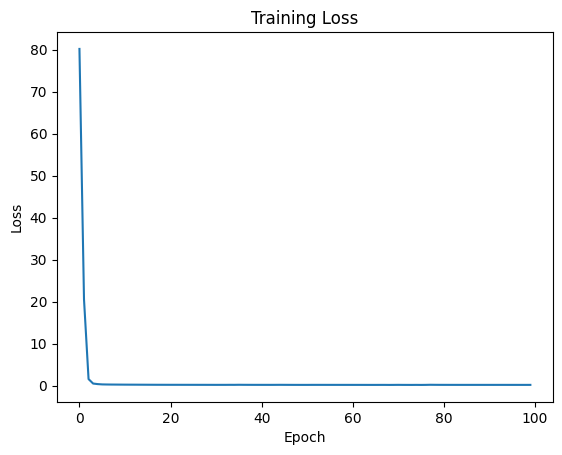

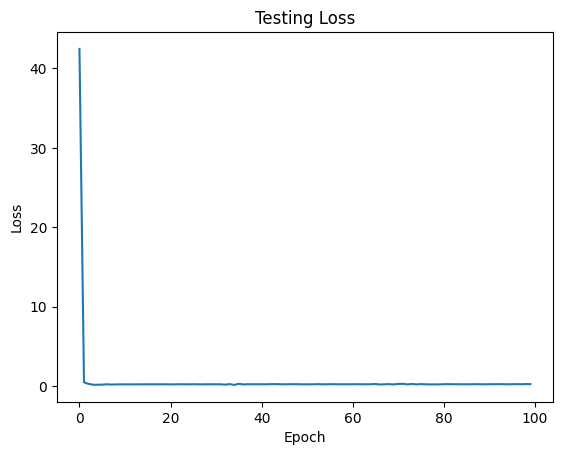

In [11]:
import matplotlib.pyplot as plt

def plot_train_loss(train_loss_list):
    plt.figure()
    plt.plot(range(len(train_loss_list)), train_loss_list)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_test_loss(test_loss_list):
    plt.figure()
    plt.plot(range(len(test_loss_list)), test_loss_list)
    plt.title('Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_train_loss(train_loss_list)
plot_test_loss(test_loss_list)

---

1. batch size 100 -> 10000  
    - 100  
        |||
        |--|--|
        | 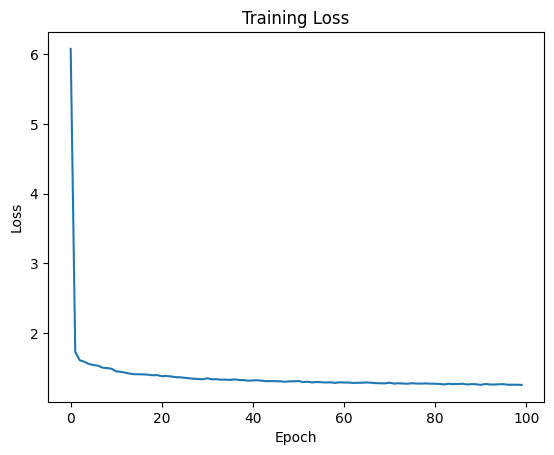 | 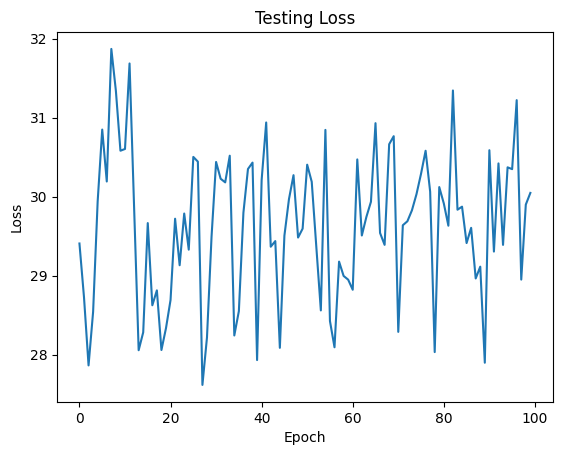 |  

    - 10000  
        |||
        |--|--|
        | 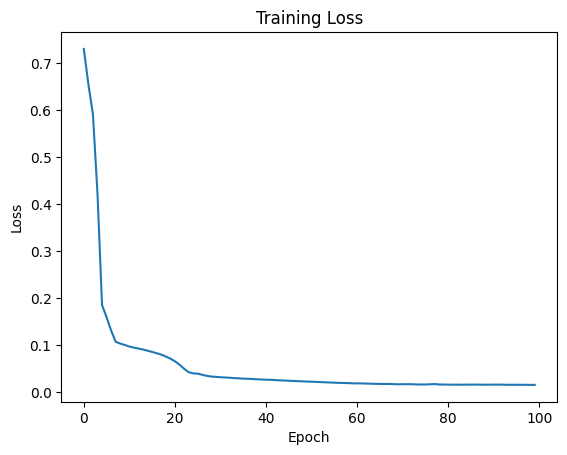 | 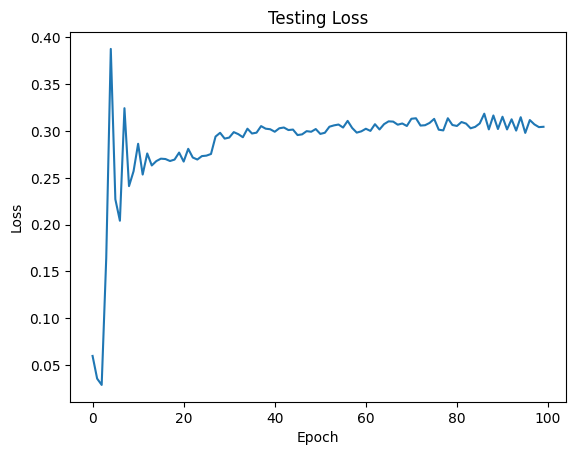 |  

2. 1 (batch size 10000) + learning rate 0.001 -> 0.1
    - 0.001
        |||
        |--|--|
        | 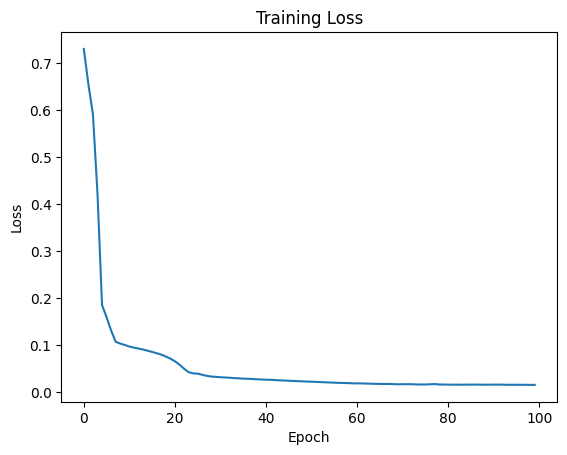 | 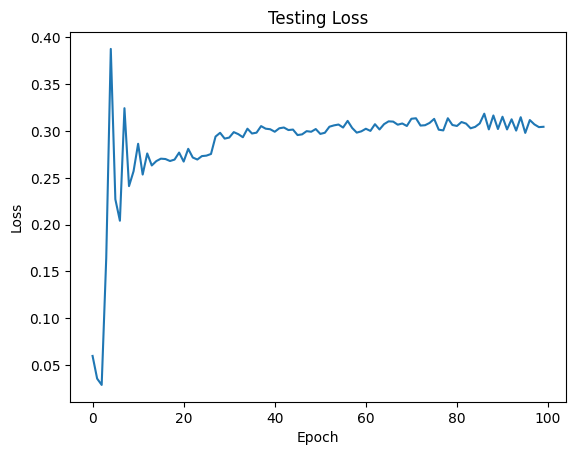 | 
    
    - 0.1  
        |||
        |--|--|
        | 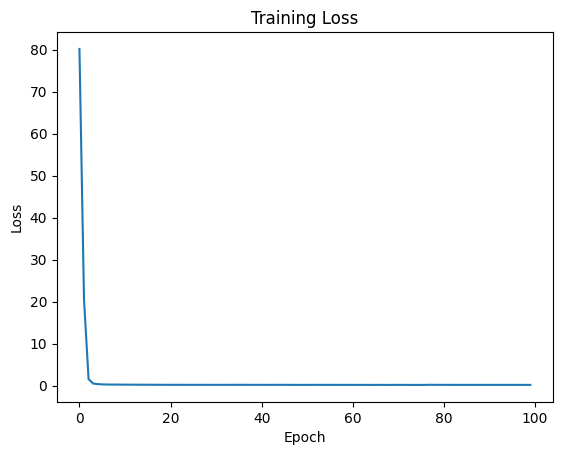 | 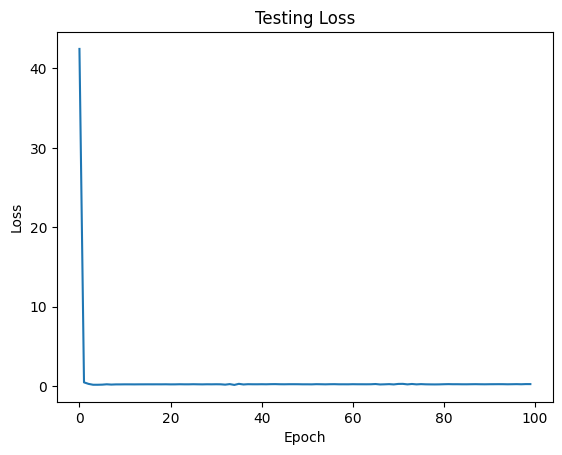 |

---

In [20]:
# Predicting N months
N = 12  # 預測未來N天的氣溫

# Extract the second column
mean_temps = df['Temperature (C)']

# Pick P points randomly in data as starting
P = 10  # 10組prediction
# points = np.random.randint(dataset.sample_len, high=len(dataset), size=P)  # 隨機抓每一組的預測起始點
points = np.random.randint(dataset.sample_len, 5000, size=P)  # 範圍在5000以內
preds = np.zeros((P, N))

# Forcast temperature for N months
for idx_i, i in enumerate(points):
    normalized_temp, target = dataset[i]
    temperatures = normalized_temp
    temperatures = temperatures.to(device)
    
    for idx_j, j in enumerate(range(N)):
        
        ii = temperatures.view(1, dataset.sample_len+idx_j, 1).to(device)   # transform into (batch, sequence, features)
        model = model.to(device)
        pred = predict(model, device, ii).to(device)
        preds[idx_i][idx_j] = pred

        # remove first temp and append predicted data at last
        # temperatures = torch.cat((temperatures[1:], pred.view(-1)))
        temperatures = torch.cat((temperatures, pred))
    
    # Inverse transform the predictions
    actual_predictions = scaler.inverse_transform(preds[idx_i].reshape(-1, 1))  # 從normalization轉為原始氣溫值  
    preds[idx_i] = actual_predictions.reshape(-1)
    print("Predicts: ", actual_predictions)
    print("Expected: ", scaler.inverse_transform(target.reshape(-1, 1)))

Predicts:  [[23.46170059]
 [23.77756434]
 [23.83103715]
 [23.84089114]
 [23.84385727]
 [23.84426026]
 [23.84225915]
 [23.84050099]
 [23.84001598]
 [23.83987409]
 [23.83986729]
 [23.83989636]]
Expected:  [[27.28888889]]
Predicts:  [[24.31399237]
 [24.63518951]
 [24.68788339]
 [24.69762917]
 [24.70085539]
 [24.70149197]
 [24.70026548]
 [24.69760245]
 [24.69704203]
 [24.69681456]
 [24.6967646 ]
 [24.69678998]]
Expected:  [[18.91666667]]
Predicts:  [[23.38096647]
 [23.69525738]
 [23.74876237]
 [23.75859462]
 [23.7614883 ]
 [23.76179659]
 [23.75952133]
 [23.75809371]
 [23.75760765]
 [23.75748695]
 [23.75749161]
 [23.75751525]]
Expected:  [[30.97222222]]
Predicts:  [[-9.1186122 ]
 [-9.09064377]
 [-9.08317867]
 [-9.0822746 ]
 [-9.08172977]
 [-9.08135862]
 [-9.08065782]
 [-9.080056  ]
 [-9.08003138]
 [-9.08006745]
 [-9.07998606]
 [-9.07982508]]
Expected:  [[-12.80555556]]
Predicts:  [[18.97622529]
 [19.30153762]
 [19.35719897]
 [19.36651295]
 [19.36988859]
 [19.37125781]
 [19.37102208]
 [19.36

Predicted months:  range(4765, 4777)
Predicted months:  range(3739, 3751)
Predicted months:  range(3731, 3743)
Predicted months:  range(3262, 3274)
Predicted months:  range(4010, 4022)
Predicted months:  range(3400, 3412)
Predicted months:  range(4935, 4947)
Predicted months:  range(281, 293)
Predicted months:  range(2350, 2362)
Predicted months:  range(947, 959)


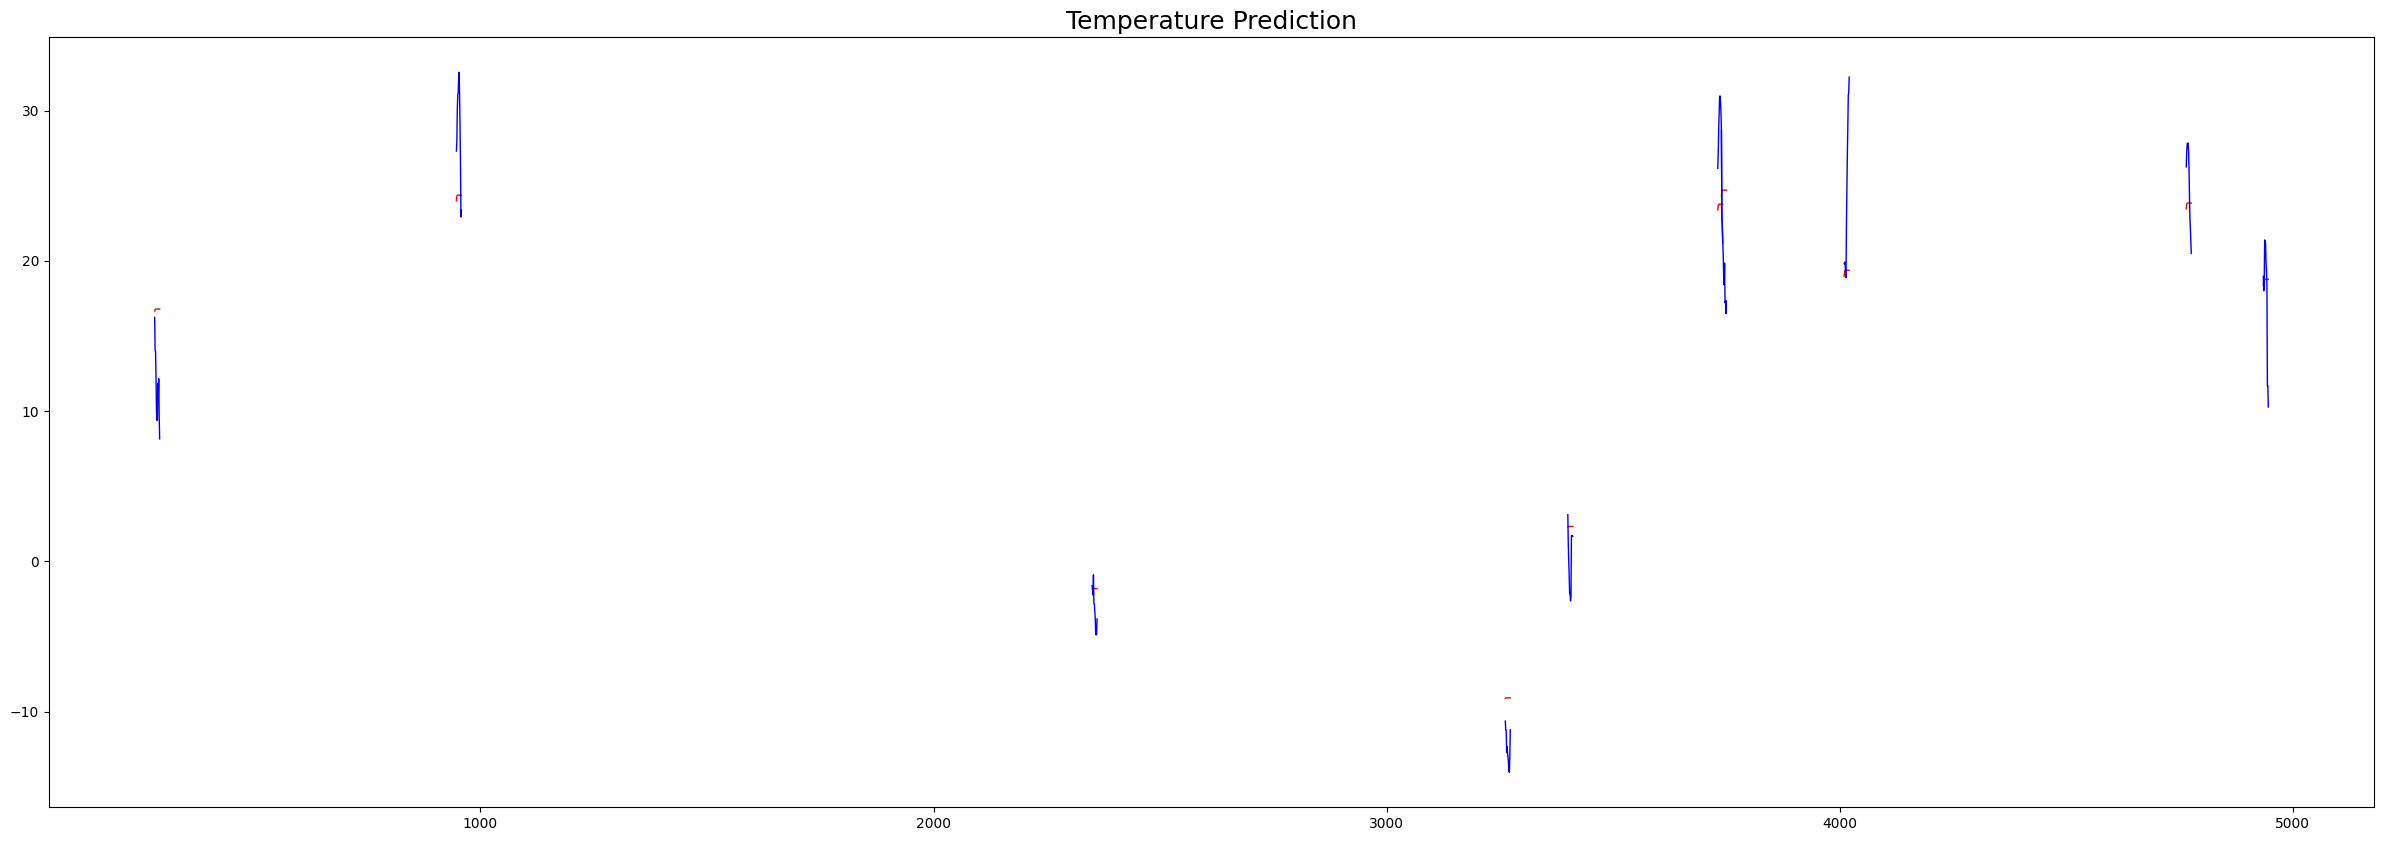

In [21]:
import matplotlib.pyplot as plt

# Data
months = range(0, df['Formatted Date'].size)

# Draw Inline
%matplotlib inline

# Draw Original Lines
plt.figure(figsize = (30,10))
plt.title('Temperature Prediction', fontsize=18)
# plt.plot(df['Formatted Date'], df['Temperature (C)'], color='b', linewidth=1)

# Draw all predicted points
for idx_i, i in enumerate(points):
    i_months = range(i, i+N)
    i_temps = preds[idx_i]
    orig_temps = df['Temperature (C)'][i:i+N]
    plt.plot(i_months, i_temps, color='r', linewidth=1)
    plt.plot(i_months, orig_temps, color='b', linewidth=1)
    print("Predicted months: ", i_months)
